In [1]:
import os
# from pyciemss.Ensemble.interfaces import (
#     load_and_sample_petri_ensemble, load_and_calibrate_and_sample_ensemble_model
# )
from pyciemss.Ensemble.interfaces import (
    setup_model,
    sample,
    calibrate,
    prepare_interchange_dictionary,
    create_solution_mapping_fns
)

from pyciemss.interfaces import DEFAULT_QUANTILES
from pyciemss.utils.interface_utils import csv_to_list

from pyciemss.PetriNetODE.interfaces import (
    load_petri_model
)

from pyciemss.visuals import plots

In [2]:
DEMO_PATH = "../../notebook/integration_demo/"
# ASKENET_PATH_1 = "https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/main/petrinet/examples/sir_typed.json"
ASKENET_PATH_1 = "../../test/models/AMR_examples/ensemble/SEIARHDS_AMR.json"
ASKENET_PATH_2 = "../../test/models/AMR_examples/ensemble/SIRHD_AMR.json"

ASKENET_PATHS = [ASKENET_PATH_1, ASKENET_PATH_2]

## load_and_sample_ensemble_model

In [3]:
weights = [0.5, 0.5]
num_samples = 100
timepoints = [0.0, 1.0, 2.0, 3.0, 4.0]
solution_mappings = [{"Infected": "Cases", "Hospitalizations": "hospitalized_population"}, # model 1 mappings
                     {"Infected": "Infections", "Hospitalizations": "hospitalized_population"} # model 2
                     ]


models = [load_petri_model(m, 
                           add_uncertainty=False, 
                           compile_observables_p=True, 
                           compile_rate_law_p=True) 
          for m in ASKENET_PATHS]

solution_mapping_fns = create_solution_mapping_fns(models, solution_mappings)

total_population = 1.0
start_time = -1e-10
dirichlet_concentration = 1.0

ensemble = setup_model(
    models,
    weights,
    solution_mapping_fns,
    start_time,
    total_population=total_population,
    dirichlet_concentration=dirichlet_concentration,
)

samples = sample(
    ensemble,
    timepoints,
    num_samples,
    method="dopri5"
)


result = prepare_interchange_dictionary(
    samples, 
    timepoints=timepoints, 
    alpha_qs=DEFAULT_QUANTILES, 
    stacking_order="timepoints", 
    visual_options={"keep":".*_sol"}
)

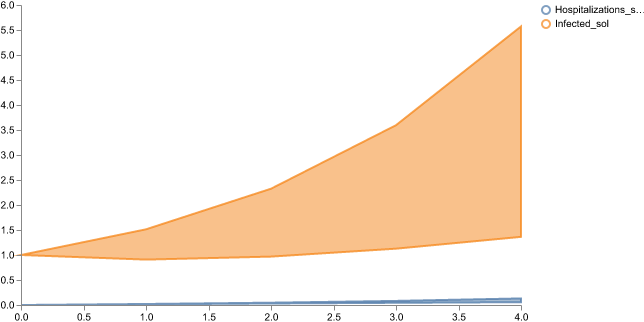

In [4]:
ensemble_samples = result["data"]
q_ensemble = result["quantiles"]

# Save results
ensemble_samples.to_csv(os.path.join(DEMO_PATH, "results_petri_ensemble/sample_results.csv"), index=False)
q_ensemble.to_csv(os.path.join(DEMO_PATH, "results_petri_ensemble/quantile_results.csv"), index=False)

plots.ipy_display(result["visual"])

## load_and_calibrate_and_sample_ensemble_model

In [5]:
# # Generate data from model
# from pyciemss.utils.interface_utils import solutions_to_observations

# data = solutions_to_observations(timepoints, result["data"].set_index(["timepoint_id", "sample_id"]))
# data[0].to_csv(os.path.join(DEMO_PATH, "results_petri_ensemble/ensemble_data.csv"), index=False)

In [6]:
data_path = os.path.join(DEMO_PATH, "results_petri_ensemble/ensemble_data.csv")
num_samples = 2
timepoints = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
method="dopri5"

data = csv_to_list(data_path)


inferred_parameters = calibrate(
    ensemble, 
    data, 
    method=method,
    verbose = False,
    verbose_every = 25)

samples = sample(
    ensemble,
    timepoints,
    num_samples,
    inferred_parameters=inferred_parameters,
    method=method
)


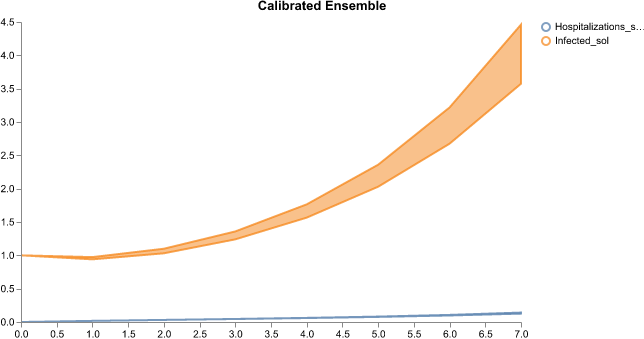

In [7]:
result = prepare_interchange_dictionary(
    samples, 
    timepoints=timepoints, 
    alpha_qs=DEFAULT_QUANTILES, 
    stacking_order="timepoints", 
    time_unit="days",
    visual_options={"title": "Calibrated Ensemble", "keep":".*_sol"}
)


# Save results
result["data"].to_csv(
    os.path.join(DEMO_PATH, "results_petri_ensemble/calibrated_sample_results.csv"), index=False
)
result["quantiles"].to_csv(
    os.path.join(DEMO_PATH, "results_petri_ensemble/calibrated_quantile_results.csv"), index=False
)
plots.ipy_display(result["visual"])

In [8]:
from pyciemss.utils.interface_utils import cdc_reformatcsv

# if the 'max' arg
q_ensemble_data = cdc_reformatcsv(filename=os.path.join(DEMO_PATH, "results_petri_ensemble/calibrated_quantile_results.csv"), 
                                  solution_string_mapping={"Infected": "case", "Hospitalizations": "hosp.", "D": "death"}, 
                                  forecast_start_date="2023-08-03",
                                  location="US",
                                  drop_column_names=["timepoint_id", "number_days", "inc_cum", "output", "Forecast_Backcast"])
q_ensemble_data.to_csv(os.path.join(DEMO_PATH, "results_petri_ensemble/CDCformat_calibrated_quantile_results.csv"), index=False)

ValueError: No 'backcast' entries found in source data (required for CDC format)